<a href="https://colab.research.google.com/github/lesi-nedo/ISPR_assignments/blob/main/Assignment_6_o_nedobiychuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center" ><b> <font face="Rage" size=7 >SIFT Descriptors</font></b></div>

<div align="center" ><b> <font face="Rage" size=5 >Assignment 6</font></b></div>
<div align="center" ><b> <font face="Rage" size=4 >Oleksiy Nedobiychuk</font></b></div>


In [2]:
from google.colab import drive
import os
import cv2



drive.mount('/content/drive/')
uploaded = {}
path = '/content/drive/My Drive/horse/'
for filename in os.listdir(path):
  uploaded[filename] = cv2.cvtColor(cv2.imread(path + filename), cv2.COLOR_BGR2GRAY)



Mounted at /content/drive/


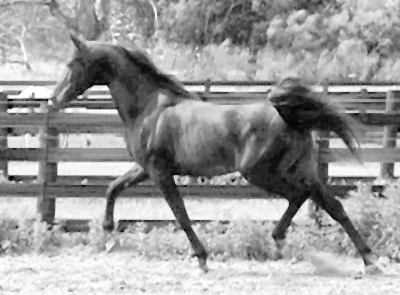

In [3]:
import numpy as np
from google.colab.patches import cv2_imshow
import io


all_images_len = len(uploaded)

last = all_images_len - 1

default_shape = (400,295)
all_images = np.empty([all_images_len, default_shape[1], default_shape[0]], dtype=np.uint8)
gamma = 1.5 # The value for the gamma correction
invGamma = 1.0 / gamma
resized = None
first_img = None

for ind, image in enumerate(uploaded.values()):
  resized = cv2.resize(image, default_shape, interpolation=cv2.INTER_LANCZOS4) # all images are resized
  if first_img is None:
    first_img = resized
  eq_img = cv2.equalizeHist(resized) # to improve contrast, I've done the histogram equalization
  mdb_img = cv2.medianBlur(eq_img, 3) # to reduce noise, I've blured the image
  table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0,256)]).astype("uint8")
  gcor_img = cv2.LUT(mdb_img, table) #Computes the gamma correction of the image with the table
  all_images[ind] = gcor_img

cv2_imshow(all_images[last])



In [4]:
sift = cv2.SIFT_create()
all_descriptors = []

def norm_descriptors(desc):
  norms = np.linalg.norm(desc, axis=1, keepdims=True)
  norms[norms == 0] = 1e-8
  return desc / norms
kp = None
first_kp = None


for ind,gray in enumerate(all_images):
  kp = sift.detect(gray, None)
  kp, des = sift.compute(gray, kp)
  if first_kp is None:
    first_kp = kp
  des = norm_descriptors(des)
  all_descriptors.append(des)


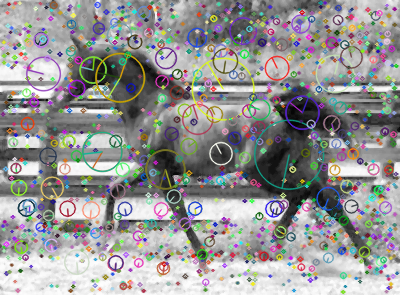

In [5]:
img_with_keypoints = cv2.drawKeypoints(all_images[last], kp, resized, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2_imshow(img_with_keypoints)

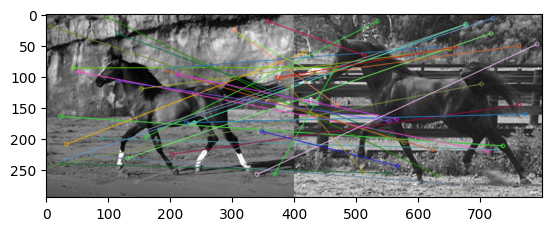

(<matplotlib.image.AxesImage at 0x7825c9965930>, None)

In [6]:
import matplotlib.pyplot as plt

bf = cv2.BFMatcher()

matches = bf.knnMatch(all_descriptors[0], all_descriptors[last], k=2)


good = []

for m,n in matches:
  if m.distance < .8 * n.distance:
    good.append([m])


img3 = cv2.drawMatchesKnn(first_img, first_kp, resized, kp, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

In [7]:
from sklearn.cluster import DBSCAN
eps = 0.55
min_samples = 4
all_labels = []

clustering = DBSCAN(eps=eps, min_samples=min_samples)
for des in all_descriptors:
  np_d = np.array(des)
  clustering.fit(np_d)
  labels = clustering.labels_
  all_labels.append(labels)


1350 marked as noise,  239 marked as part of a cluster


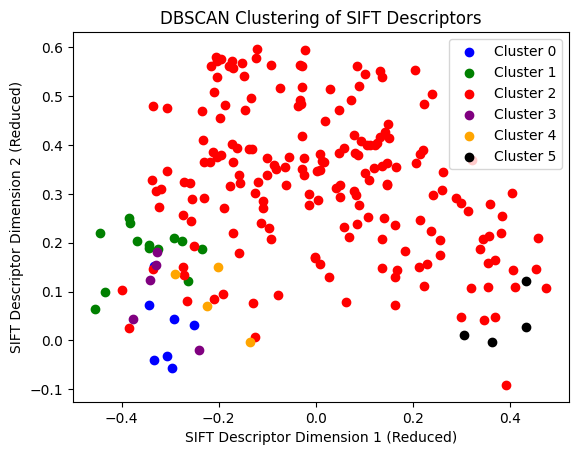

In [8]:
from sklearn.decomposition import PCA

noise_ = len(all_labels[0][all_labels[0] == -1])
print(noise_, "marked as noise, ", len(all_labels[0]) - noise_, "marked as part of a cluster")

def plot_des(all_labels_img, ind=0, alg='DBSCAN'):
  pca = PCA(n_components=2)
  reduced_des = pca.fit_transform(all_descriptors[ind])
  unique_lab_ = set(all_labels_img[ind])
  cluster_colors = ['blue', 'green', 'red', 'purple', 'orange', 'black', 'yellow']
  for lab in unique_lab_:
    if lab == -1:
      continue
    last_lab = all_labels_img[ind]
    cluster_ind = np.where(last_lab == lab)[0]
    plt.scatter(reduced_des[cluster_ind, 0], reduced_des[cluster_ind, 1], label=f"Cluster {lab}", color=cluster_colors[lab])

  plt.xlabel('SIFT Descriptor Dimension 1 (Reduced)')
  plt.ylabel('SIFT Descriptor Dimension 2 (Reduced)')
  plt.title(f'{alg} Clustering of SIFT Descriptors')
  plt.legend()
  plt.show()

plot_des(all_labels, last)

In [9]:
from enum import auto
from sklearn.cluster import KMeans

n_clusters = 3
kmeans = KMeans(n_clusters, random_state=0, n_init='auto')
all_kmean_labels = []
for dis in all_descriptors:
  kmeans.fit(dis)
  all_kmean_labels.append(kmeans.labels_)



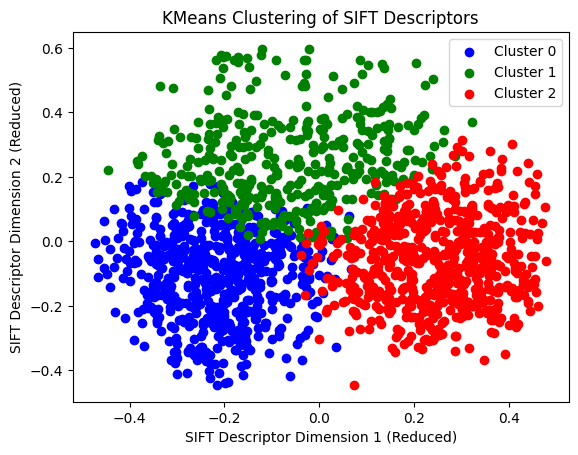

In [10]:
plot_des(all_kmean_labels, ind=last, alg='KMeans')

In [1]:
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=3)
flat_descriptors =  np.concatenate(all_descriptors, axis=0)
reduced_descriptors = pca.fit_transform(flat_descriptors)

  # Plot each cluster separately
cluster_colors = ['blue', 'green', 'red', 'purple', 'orange', 'black']  # Adjust colors
unique_ = set()
print(reduced_descriptors.shape)
fig = px.scatter_3d(reduced_descriptors)

fig.show()

NameError: name 'np' is not defined